# ZAP Data Challenge


## O problema
- Desafio
- Os dados
- Carregar os dados
- Análise rápida dos dados de Treino
- Análise rápida dos dados de Teste

## EDA Identificar Variáveis
- Quais os tipos de variáveis
- Estatísticas das variáveis idependentes e a dependente
- Tendencias e distribuições

## Relações entre as variáveis
- Plotar Correlações numéricas
- Plotar relações da váriavel dependente com as categorias

## Limpeza de Dados
- Avaliar contradições e duplicados
- Avaliando Missing Values em variáveis numéricas
- Avaliando Missing em variáveis categóricas
- Remoção, Imputação com missings

## Outiliers
- Remoção, natural log, binning, pesos

## Transformação 
- logaritima, square, raiz cúbica, binning, discretization, fatorização...

## Feature Engineering
- Agrupar 
- Amplitude
- Adição, multiplicação, divisão de features
- Extração de domínio e tempo
- Métodos de importancia de variáveis
- Hashing com geolocalização

## Feature Selection
- Filter métodos
- Wrapper métodos
- ou Embedded métodos

## Modelar e testar
- Random Forest
- XGBoost
- LightGBM


In [1]:
import json 
import pandas as pd 
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew
from scipy import stats
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from scipy.special import boxcox, inv_boxcox
from sklearn.preprocessing import StandardScaler, RobustScaler
import zaputils as zap
import pygeohash as gh
#formtando como pandas mostra números
pd.options.display.float_format = '{:,.6f}'.format
sns.set(palette='muted')
pd.set_option('max_columns', None)

## O problema
O Zap disponibiliza uma base de dados e nosso objetivo é achar o preço de *VENDA* do apartamento. 
Seu trabalho é criar uma maneira automática de estimar um preço de venda para os apartamentos no dataset de *TESTE*.
- Ou seja somente nos iteressa anúncios de *venda*
- Vamos trabalhar para previsão somente nesta base de *TESTE*
- Como não foi especificado que o modelo será reutilizado nosso objetivo é obter a menor margem de _erro_ no preço de *venda*.
- O meu tempo é muito curto, no meu caso, 1 dia então vou me conter ao básico
### Os dados

<div style="float:left">
<table>
<tr><td>usableAreas:</td><td> tamanho do imóvel em m²</td></tr>
<tr><td>description:</td><td> descrição do anúncio</td></tr>
<tr><td>title:</td><td> título do anúncio</td></tr>
<tr><td>createdAt:</td><td> timestamp da criação do anúncio</td></tr>
<tr><td>publisherId:</td><td> identificador do anunciante</td></tr>
<tr><td>unitTypes:</td><td> tipo do imóvel (apartamento, casa, comércial, etc)</td></tr>
<tr><td>listingStatus:</td><td> status do anúncio (ativo ou inativo)</td></tr>
<tr><td>id:</td><td> identificador único do anúncio</td></tr>
<tr><td>parkingSpaces:</td><td> número de vagas de garagem</td></tr>
<tr><td>updatedAt:</td><td> timestamp do último update</td></tr>
<tr><td>owner:</td><td> indicador se o anunciante é proprietário do imóvel</td></tr>
<tr><td>images:</td><td> lista de links de imagens do anúncio</td></tr>
<tr><td>address:</td><td> endereço do imóvel</td></tr>
<tr><td>country:</td><td> país do imóvel</td></tr>
<tr><td>zipCode:</td><td> CEP do imóvel</td></tr>
<tr><td>city:</td><td> cidade do imóvel</td></tr>
<tr><td>streetNumber:</td><td> número da rua</td></tr>
<tr><td>zone:</td><td> zona do imóvel</td></tr>
</table>
</div>
<div style="float:left">
<table>
<tr><td>geoLocation:</td><td> geolocalização do imóvel</td></tr>
<tr><td>street:</td><td> nome da rua</td></tr>
<tr><td>locationId:</td><td> id da localização</td></tr>
<tr><td>district:</td><td> distrito do imóvel</td></tr>
<tr><td>unitNumber:</td><td> complemento do imóvel</td></tr>
<tr><td>state:</td><td> estado federativo do imóvel</td></tr>
<tr><td>neighborhood:</td><td> bairro do imóvel</td></tr>
<tr><td>publicationType:</td><td> tipo de publicação do anúncio (normal ou premium)</td></tr>
<tr><td>bathrooms:</td><td> número de banheiros</td></tr>
<tr><td>totalAreas:</td><td> área total do imóvel em m²</td></tr>
<tr><td>bedrooms:</td><td> número de quartos</td></tr>
<tr><td>suites:</td><td> número de suites</td></tr>
<tr><td>princingInfos:</td><td> informações do preço</td></tr>
<tr><td>price:</td><td> preço de venda</td></tr>
<tr><td>yearlyIptu:</td><td> preço do IPTU</td></tr>
<tr><td>businessType:</td><td> tipo do anúncio (venda, aluguel ou ambos)</td></tr>
<tr><td>monthlyCondoFee:</td><td> condomínio</td></tr>
<tr><td>rentalTotalPrice:</td><td> preço do aluguel</td></tr>
</table>
</div>
<div style="clear: both;"></div>

### Observações
- São apresentados no formato json e tem sub datasets portanto devem ser normalizados
- Foi criado um arquivo helper, para manter o notebook mais limpo vou colocar as funções criadas nele, para analise do código favor consultar o zaputils.py
- Vou descartar os links de imagens, nesse momento não daria tempo modelar as imagens


In [2]:
#carregando dados de treino e teste
train = zap.readAndFlatDataSet('source-4-ds-train.json')
train_eda = train.loc[:,['address.city', 'address.country', 'address.district','address.street',
       'address.geoLocation.location.lat', 'address.geoLocation.location.lon',
       'address.geoLocation.precision', 'address.locationId',
       'address.neighborhood', 'address.state', 'address.zipCode',
       'address.zone', 'bathrooms', 'bedrooms', 'createdAt', 'description',
       'id', 'listingStatus', 'owner', 'parkingSpaces',
       'pricingInfos.businessType', 'pricingInfos.monthlyCondoFee',
       'pricingInfos.period', 'pricingInfos.price',
       'pricingInfos.rentalTotalPrice', 'pricingInfos.yearlyIptu',
       'publicationType', 'publisherId', 'suites', 'title', 'totalAreas',
       'unitTypes', 'updatedAt', 'usableAreas']].copy()

test = zap.readAndFlatDataSet('source-4-ds-test.json')
test = test.loc[:,['address.city', 'address.country', 'address.district','address.street',
       'address.geoLocation.location.lat', 'address.geoLocation.location.lon',
       'address.geoLocation.precision', 'address.locationId',
       'address.neighborhood', 'address.state', 'address.zipCode',
       'address.zone', 'bathrooms', 'bedrooms', 'createdAt', 'description',
       'id', 'listingStatus', 'owner', 'parkingSpaces',
       'pricingInfos.businessType', 'pricingInfos.monthlyCondoFee',
       'pricingInfos.period', 'pricingInfos.price',
       'pricingInfos.rentalTotalPrice', 'pricingInfos.yearlyIptu',
       'publicationType', 'publisherId', 'suites', 'title', 'totalAreas',
       'unitTypes', 'updatedAt', 'usableAreas']]

In [3]:
# Análise rápida dados de treino
zap.getSomeStats(train_eda, 'pricingInfos.price')

Data shape: (133964, 34)
ooooooooooooooooooooooooooo
Data types:
 object     21
float64    11
bool        1
int64       1
Name: types, dtype: int64
ooooooooooooooooooooooooooo


,types,counts,distincts,nulls,null_ratio,uniques,skewness,kurtosis,corr pricingInfos.price
address.city,object,133964,1,0,0.000000,[[São Paulo]],nan,nan,nan
address.country,object,133964,2,0,0.000000,"[[BR, ]]",nan,nan,nan
address.district,object,133964,3,0,0.000000,"[[, Jaraguá, Jaçanã]]",nan,nan,nan
address.street,object,133964,12933,0,0.000000,"[[Rua Juvenal Galeno, Rua Juruaba, Avenida Pau...",nan,nan,nan
address.geoLocation.location.lat,float64,133953,43492,11,0.008000,"[[-23.612923, -23.643962, -23.568559, -23.5980...",129.964314,"18,533.095737",-0.017469
address.geoLocation.location.lon,float64,133953,45040,11,0.008000,"[[-46.614222, -46.593475, -46.647452, -46.6827...",140.698116,"20,602.339939",-0.014008
address.geoLocation.precision,object,133953,6,11,0.008000,"[[ROOFTOP, RANGE_INTERPOLATED, GEOMETRIC_CENTE...",nan,nan,nan
address.locationId,object,133964,1185,0,0.000000,[[BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim ...,nan,nan,nan
address.neighborhood,object,133964,1634,0,0.000000,"[[Jardim da Saúde, Vila Santa Teresa (Zona Sul...",nan,nan,nan
address.state,object,133964,4,0,0.000000,"[[São Paulo, SP, , Santa Catarina]]",nan,nan,nan


In [4]:
train_eda.describe(include=[np.object,np.bool]).T

,count,unique,top,freq
address.city,133964,1,São Paulo,133964
address.country,133964,2,,120112
address.district,133964,3,,133951
address.street,133964,12933,,7002
address.geoLocation.precision,133953,5,ROOFTOP,75073
address.locationId,133964,1185,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Moema,4057
address.neighborhood,133964,1634,Jardim Paulista,4284
address.state,133964,4,São Paulo,133714
address.zipCode,133964,15925,,5908
address.zone,133964,6,,116265


In [5]:
train_eda.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
address.geoLocation.location.lat,"133,953.000000",-23.554263,0.165147,-23.848153,-23.594475,-23.558990,-23.527634,0.000000
address.geoLocation.location.lon,"133,953.000000",-46.643395,0.318494,-46.820973,-46.684151,-46.654071,-46.607885,0.000000
bathrooms,"133,051.000000",2.375683,2.146044,0.000000,1.000000,2.000000,3.000000,200.000000
bedrooms,"130,945.000000",2.327023,2.140123,0.000000,2.000000,2.000000,3.000000,600.000000
parkingSpaces,"129,539.000000",2.443187,5.251624,0.000000,1.000000,2.000000,3.000000,589.000000
pricingInfos.monthlyCondoFee,"117,127.000000","1,507.678520","77,954.055478",0.000000,0.000000,399.000000,861.000000,"24,430,000.000000"
pricingInfos.price,"133,964.000000","663,748.351811","1,317,731.679053",70.000000,"175,000.000000","371,000.000000","700,000.000000","84,000,000.000000"
pricingInfos.rentalTotalPrice,"28,714.000000","11,021.829874","77,012.229803",0.000000,"2,310.000000","4,111.500000","9,100.000000","11,900,000.000000"
pricingInfos.yearlyIptu,"114,612.000000","4,182.520076","850,109.115348",0.000000,0.000000,84.000000,364.000000,"283,024,210.000000"
suites,"120,347.000000",1.106534,1.218938,0.000000,0.000000,1.000000,2.000000,80.000000


In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_eda[['bathrooms', 'bedrooms', 'parkingSpaces',
       'pricingInfos.monthlyCondoFee','pricingInfos.price',
       'pricingInfos.rentalTotalPrice','suites', 'totalAreas','usableAreas']],
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis dos dados de treino')
plt.show()

## Analise dos dados de Treino
- De cara vemos que as variáveis numéricas possuem outliers, a assimetria com caudas logas a direita,  e a curtose é enorme em alguma delas inclusive na dependente, vamos ter que normalizar os dados
- As correlações não são altas, apenas na variável preço de aluguel, porêm provavelmente não usaremos alugueis, pois o que nos interessa é venda e a taxa de missing é acima de 70%
- Periodo e preço de aluguel possuem taxa enorme de missings, candidatos a remoção
- Iptu praticamente não tem correlação, remover tambêm
- As datas tb serão removidas não vou ter tempo para analisar
- Endereços, ceps e zondas podem ser substituidos por um geohashing
- Neighborhood não tem nulos quem sabe um top target encoding, ou até mesmo mean encoding?
- Total areas contém muitos nulos tambêm e pelo que notei não há uma maneira de calcula-lo automáticamente com os dados que temos, um candidato a remoção
- City, country e district, listingstatus não contem nada relevante
- publisherid, id, title, description irei remover provavelmente é claro que as descrições podem ter muito valor, mas no momento quero uma solução simples
- Unittypes e zonas não contem cardinalidade grande podemos categorizar com One Hot, note que zones possui o top em branco...
- Preço primeiro quartil 170k e mínimo 70 reais? Vejam os outiliers ai minha gente!
- MonthlyCondoFee com o terceiro quartil 700 e Max de 24 milhões? temos que ver isso
- 4284 Apartamentos no jardim paulista!
- Um standardscaler ou minmax não vão dar conta de tantos outliers considero já para variáveis numéricas uma normalização boxcox ou robustscaler


In [6]:
#analise rápida dados de teste
zap.getSomeStats(test)

Data shape: (16036, 34)
ooooooooooooooooooooooooooo
Data types:
 object     22
float64    10
bool        1
int64       1
Name: types, dtype: int64
ooooooooooooooooooooooooooo


,types,counts,distincts,nulls,null ratio,uniques,skewness,kurtosis
address.city,object,16036,1,0,0.000000,[[São Paulo]],nan,nan
address.country,object,16036,2,0,0.000000,"[[BR, ]]",nan,nan
address.district,object,16036,1,0,0.000000,[[]],nan,nan
address.geoLocation.location.lat,float64,16033,8899,3,0.019000,"[[-23.557225, -23.592852, -23.493609, -23.6079...",85.216399,"7,503.512090"
address.geoLocation.location.lon,float64,16033,8923,3,0.019000,"[[-46.662765, -46.581879, -46.638456, -46.6861...",87.725079,"7,799.608427"
address.geoLocation.precision,object,16033,6,3,0.019000,"[[GEOMETRIC_CENTER, ROOFTOP, APPROXIMATE, RANG...",nan,nan
address.locationId,object,16036,602,0,0.000000,[[BR>Sao Paulo>NULL>Sao Paulo>Centro>Consolaca...,nan,nan
address.neighborhood,object,16036,801,0,0.000000,"[[Consolação, Quinta da Paineira, Chora Menino...",nan,nan
address.state,object,16036,2,0,0.000000,"[[São Paulo, SP]]",nan,nan
address.street,object,16036,3059,0,0.000000,"[[Rua Bela Cintra, Rua Bruno Cavalcanti Feder,...",nan,nan


In [7]:
test.describe(include=[np.object,np.bool]).T

,count,unique,top,freq
address.city,16036,1,São Paulo,16036
address.country,16036,2,,14503
address.district,16036,1,,16036
address.street,16036,3059,,720
address.geoLocation.precision,16033,5,ROOFTOP,9108
address.locationId,16036,602,BR>Sao Paulo>NULL>Sao Paulo>Centro>Higienopolis,614
address.neighborhood,16036,801,Higienópolis,432
address.state,16036,2,São Paulo,15989
address.zipCode,16036,4231,,638
address.zone,16036,6,,14090


In [8]:
test.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
address.geoLocation.location.lat,"16,033.000000",-23.558230,0.267507,-23.744563,-23.599426,-23.560475,-23.538932,0.000000
address.geoLocation.location.lon,"16,033.000000",-46.642554,0.524534,-46.803329,-46.683541,-46.653328,-46.615534,0.000000
bathrooms,"16,035.000000",2.257187,1.670712,0.000000,1.000000,2.000000,3.000000,99.000000
bedrooms,"16,036.000000",2.581754,0.976679,0.000000,2.000000,3.000000,3.000000,54.000000
parkingSpaces,"15,772.000000",1.739538,1.146988,0.000000,1.000000,1.000000,2.000000,20.000000
pricingInfos.monthlyCondoFee,"15,100.000000","1,470.143377","37,617.894154",0.000000,278.000000,475.000000,875.000000,"3,072,300.000000"
pricingInfos.rentalTotalPrice,14.000000,183.500000,686.594130,0.000000,0.000000,0.000000,0.000000,"2,569.000000"
pricingInfos.yearlyIptu,"13,639.000000","5,794.045531","599,528.359472",0.000000,0.000000,70.000000,308.000000,"70,000,000.000000"
suites,"14,641.000000",1.172324,1.125591,0.000000,0.000000,1.000000,2.000000,5.000000
totalAreas,"9,942.000000",252.474754,"6,764.673783",0.000000,56.000000,85.000000,160.000000,"665,420.000000"


### Breve analise de Teste
- UnitTypes somente apartamento
- BusinessTypes somente SALES
- 432 ap's em higienópolis!


## EDA
### Variável Dependente
- A kurtosis e skewing são enormes, é impressionante, somente conseguiremos visualizar se usarmos limite, nem normalização, minmax consegue lidar muito bem com taxas tão altas

### Relações com outras variáveis
- Uma possibilidade é removermos os outliers, somente uma possibilidade tempos que avaliar
- Depois de avaliar os plots abaixo notei que é inviavel fazer vizualizações sem remoção de outliers, então vou começar por ai.
- Observem os plots de regresão, como outliers influenciam um slope totalmente diferente

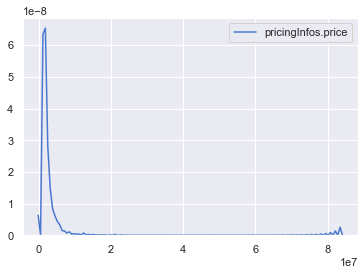

In [10]:
y = train_eda['pricingInfos.price']
sns.kdeplot(y)

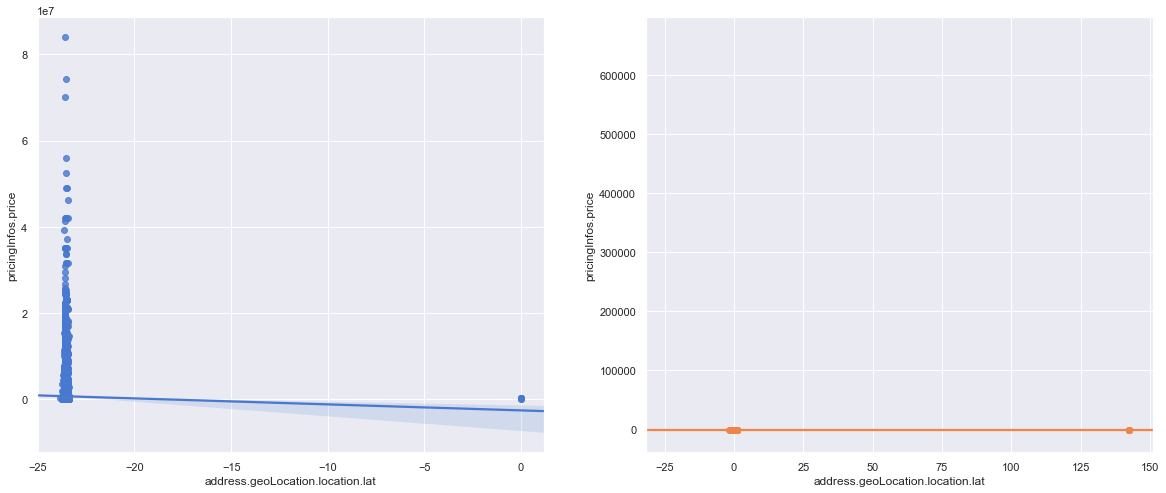

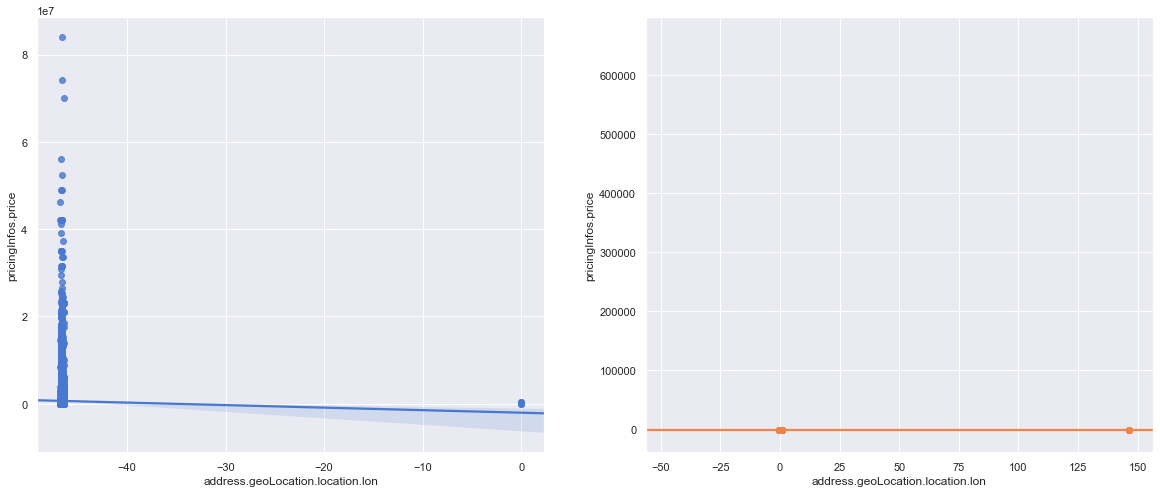

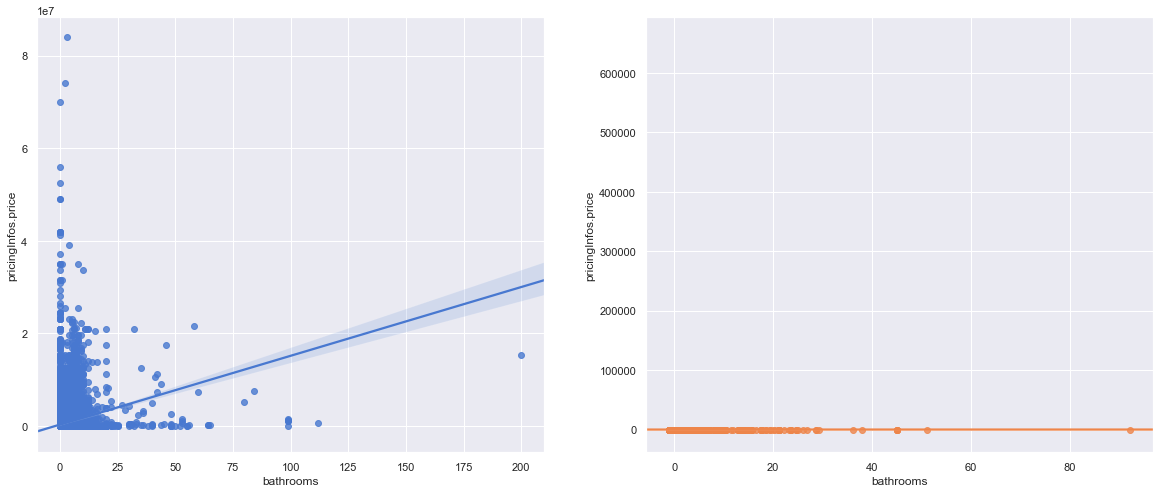

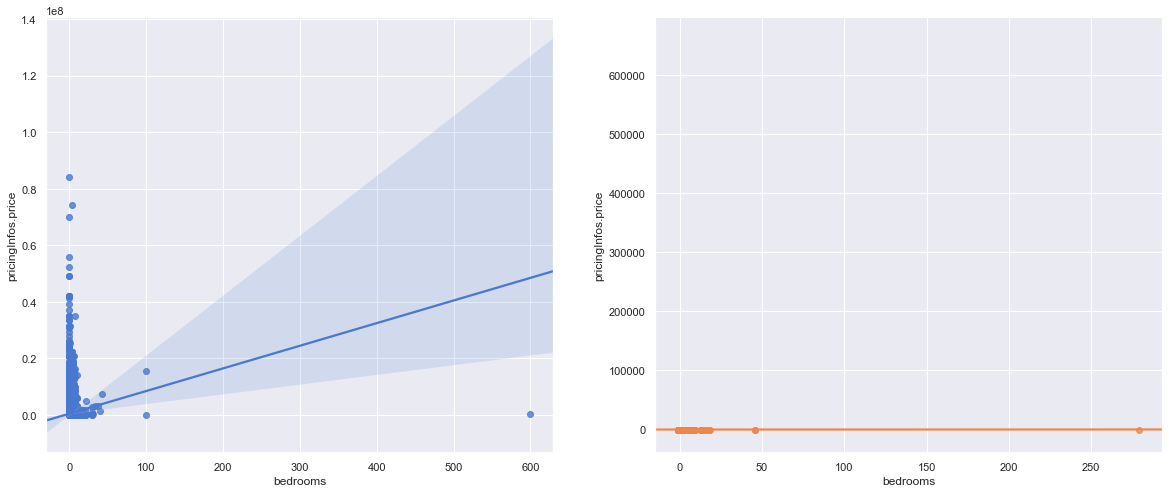

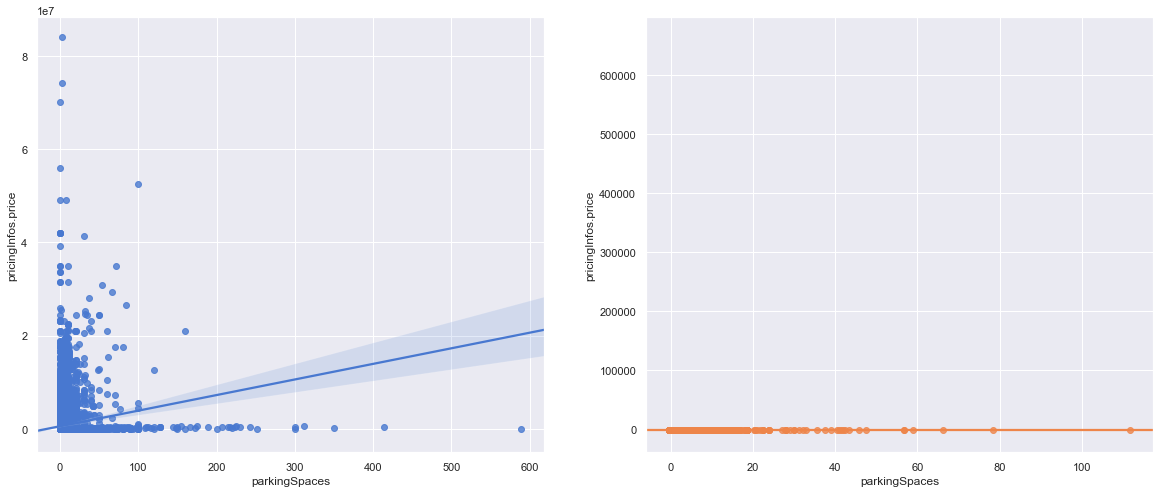

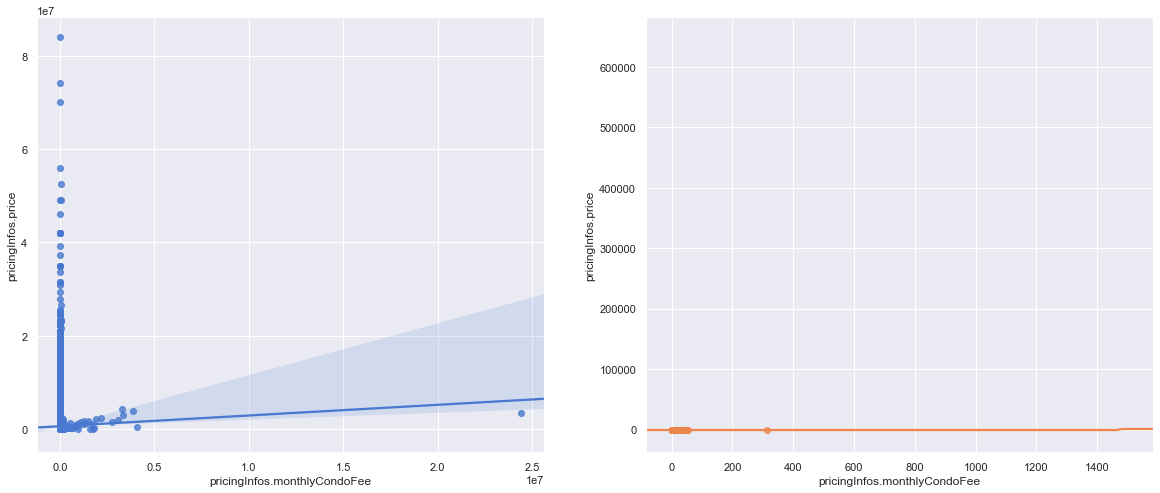

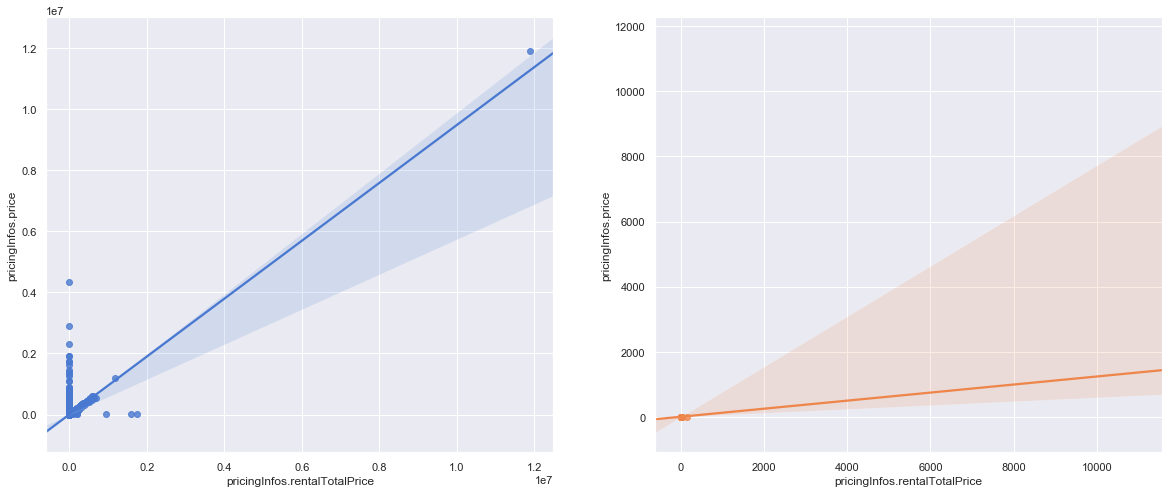

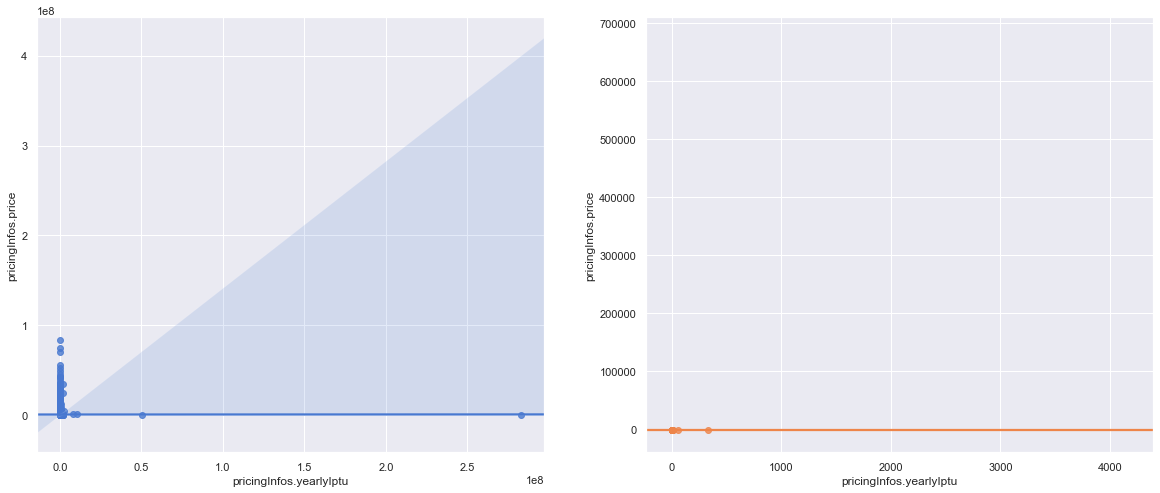

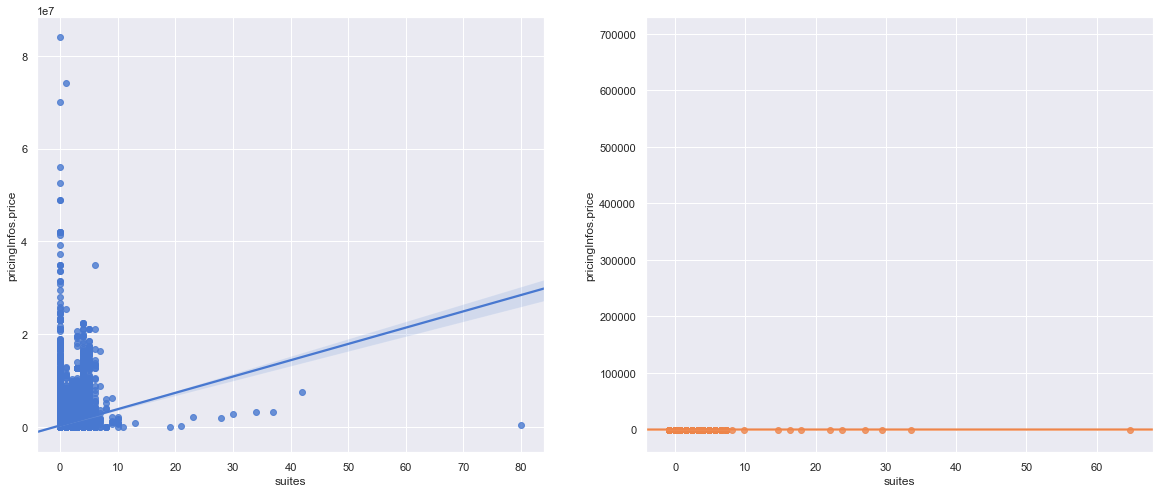

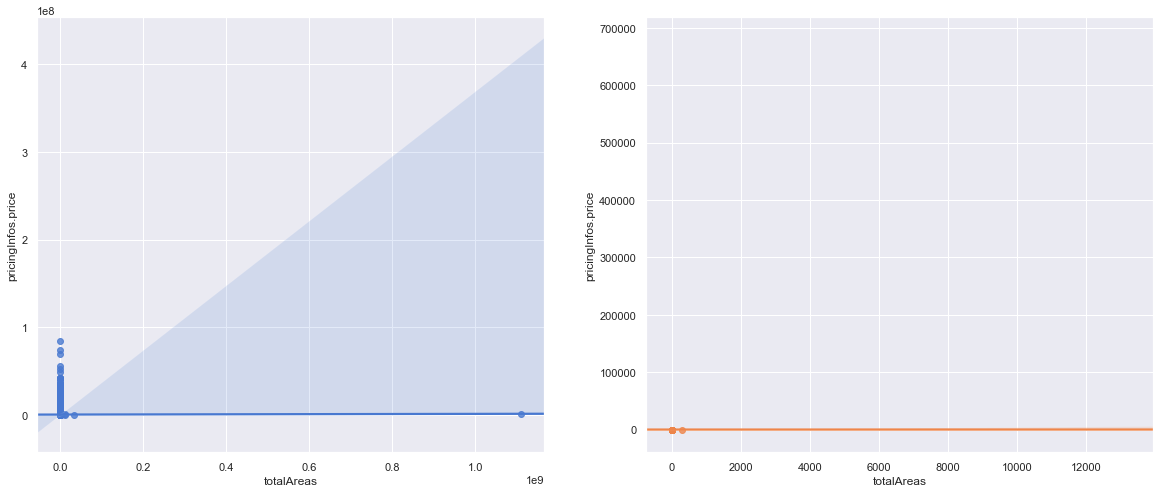

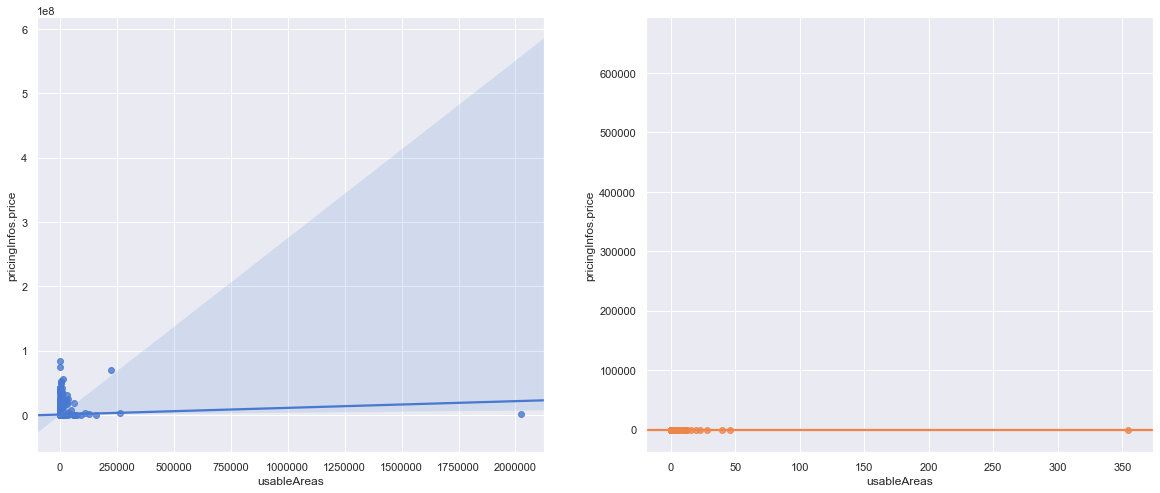

In [12]:
zap.plotRegressionPlot(train_eda)

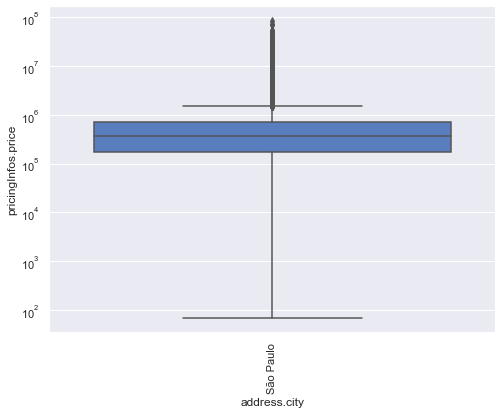

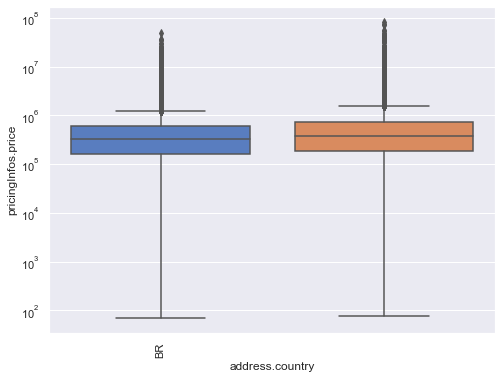

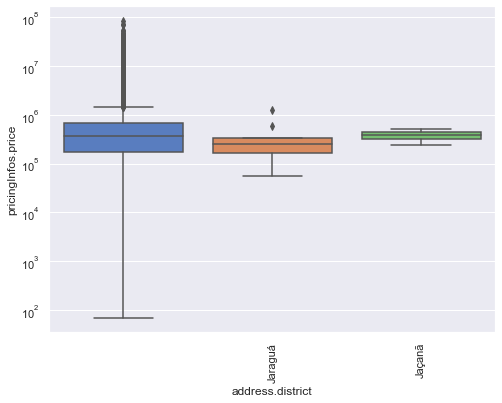

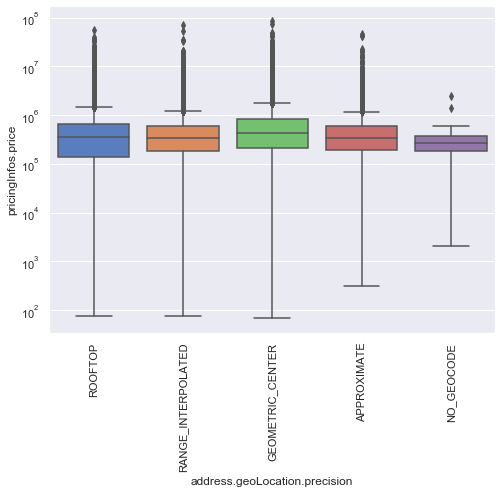

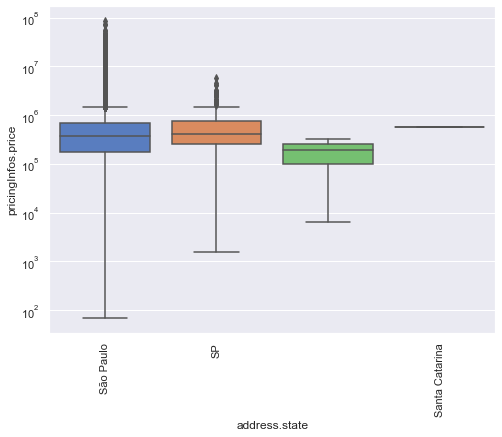

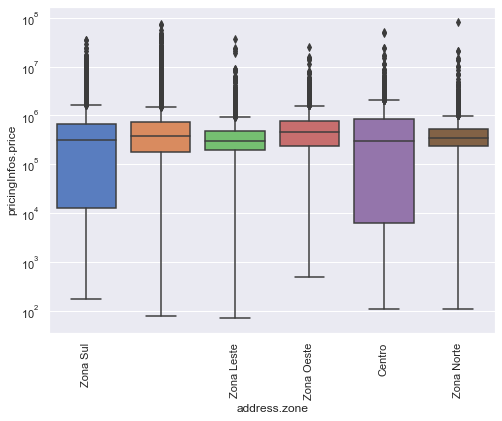

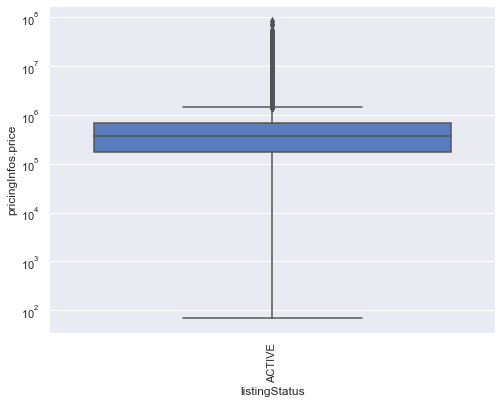

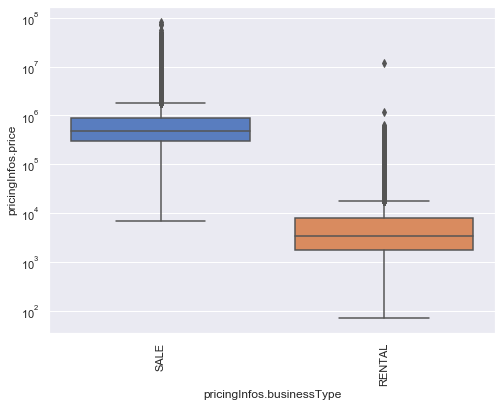

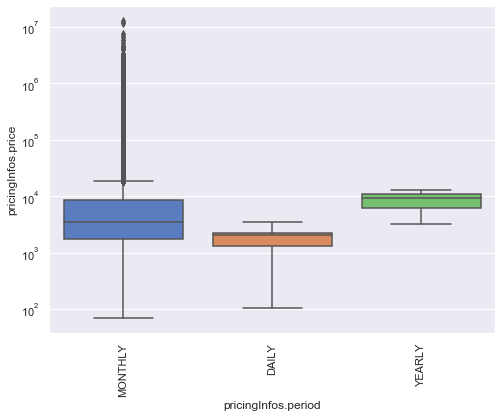

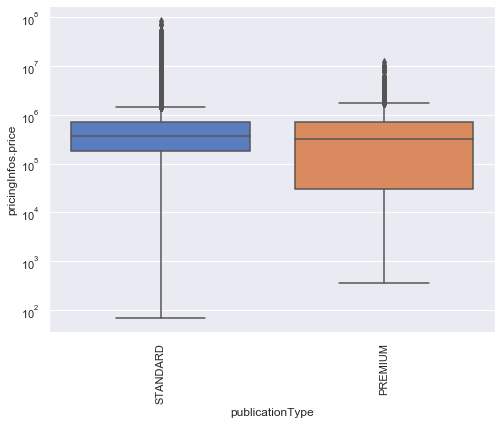

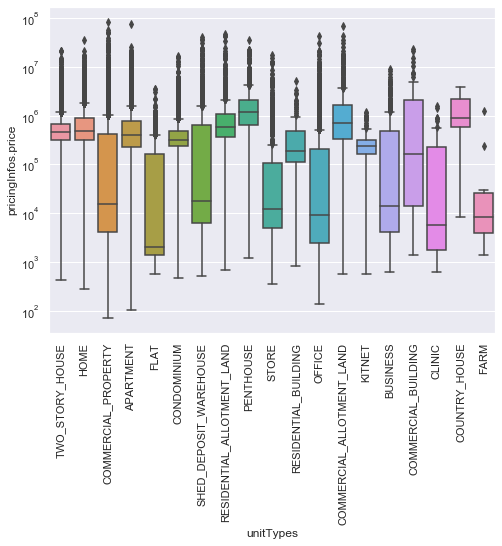

In [14]:
zap.plotBoxCategories(train_eda)

São Paulo    133964
Name: address.city, dtype: int64


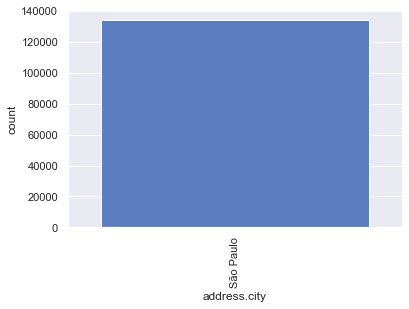

      120112
BR     13852
Name: address.country, dtype: int64


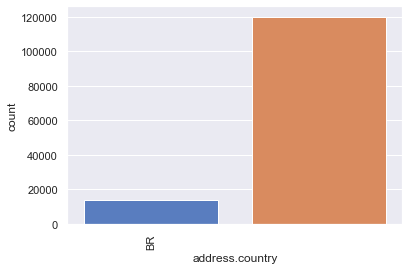

           133951
Jaraguá        11
Jaçanã          2
Name: address.district, dtype: int64


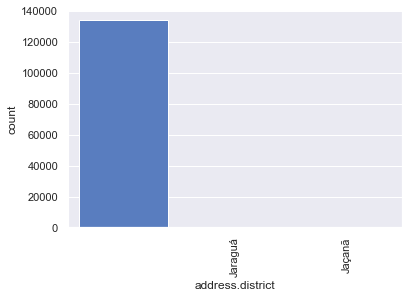

ROOFTOP               75073
GEOMETRIC_CENTER      37623
RANGE_INTERPOLATED    14137
APPROXIMATE            7090
NO_GEOCODE               30
Name: address.geoLocation.precision, dtype: int64


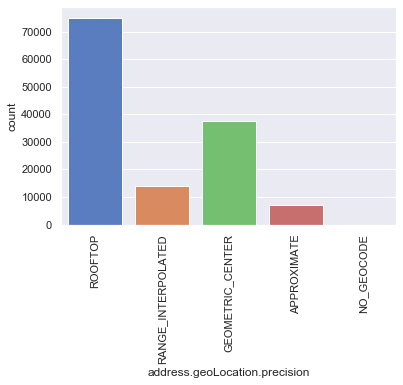

São Paulo         133714
SP                   246
                       3
Santa Catarina         1
Name: address.state, dtype: int64


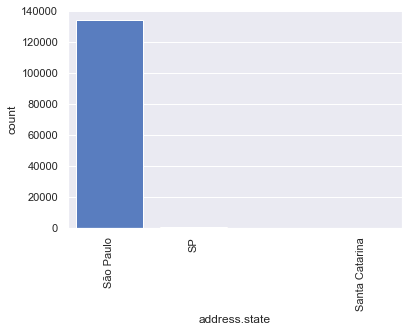

              116265
Zona Sul        5193
Zona Norte      3847
Centro          3243
Zona Leste      3107
Zona Oeste      2309
Name: address.zone, dtype: int64


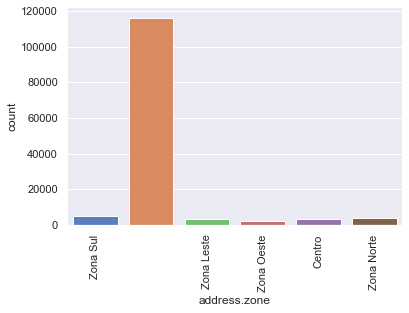

ACTIVE    133964
Name: listingStatus, dtype: int64


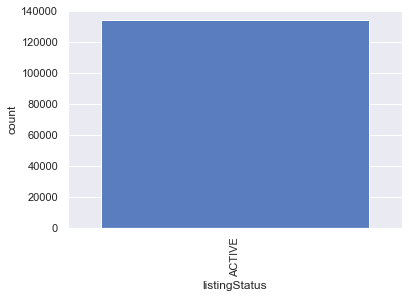

SALE      105332
RENTAL     28632
Name: pricingInfos.businessType, dtype: int64


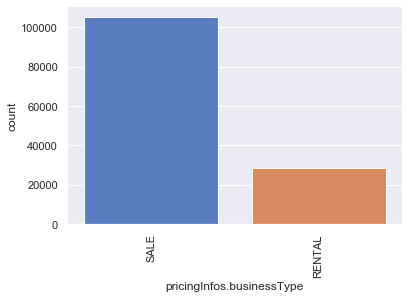

MONTHLY    29029
DAILY         19
YEARLY         3
Name: pricingInfos.period, dtype: int64


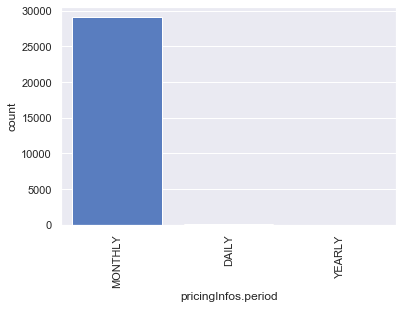

STANDARD    131595
PREMIUM       2369
Name: publicationType, dtype: int64


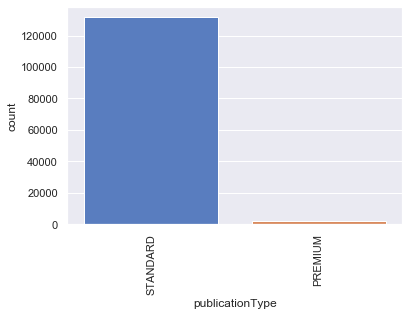

APARTMENT                     72241
TWO_STORY_HOUSE               18068
HOME                           9030
OFFICE                         7714
FLAT                           7661
COMMERCIAL_PROPERTY            5871
CONDOMINIUM                    4015
PENTHOUSE                      2772
SHED_DEPOSIT_WAREHOUSE         2197
RESIDENTIAL_ALLOTMENT_LAND     1430
COMMERCIAL_ALLOTMENT_LAND       807
STORE                           694
BUSINESS                        663
KITNET                          522
RESIDENTIAL_BUILDING            142
COMMERCIAL_BUILDING              85
CLINIC                           33
FARM                             10
COUNTRY_HOUSE                     9
Name: unitTypes, dtype: int64


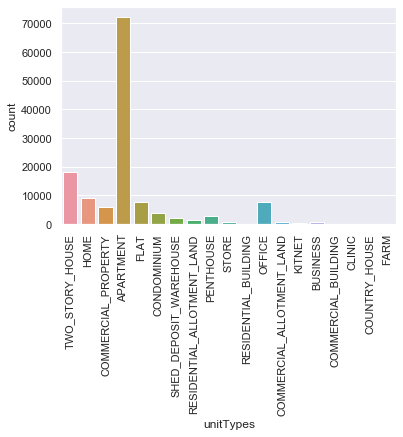

In [13]:
zap.plotBarCategories(train_eda)

## Outliers

*Nossa base de treino está totalmente assimetrica e contem muitos outliers primeiro vou remove-los de acordo com a base de teste*

Um outlier é um ponto de dados que é significativamente distante dos dados restantes. "Um outlier é uma observação que se desvia tanto das outras observações que desperta suspeitas de que foi gerada por um mecanismo diferente." [D. Hawkins. Identificação de Outliers, Chapman e Hall, 1980].
Estatísticas como média e variância são muito suscetíveis a outliers. Além disso, alguns modelos de Aprendizado de Máquina são realmente sensíveis a valores discrepantes e seu desempenho pode ser prejudicado por eles. Assim, é prática comum projetar os recursos para minimizar o impacto de outliers no desempenho desses algoritmos.

### Natureza dos outliers

- Valores extremamente altos ou extremamente baixos
- Causado por erro mecânico (medição incorreta)
- Causado pela substituição de valores ausentes (NA) por um valor fora da distribuição 

### Como podemos pré-processar outliers?

- Média / mediana de imputação ou amostragem aleatória
- Discrestisation
- Remover os outliers: processo também chamado de Trimming
- Top-coding, bottom-coding e zero-coding: também conhecido como windsorização

### Média / mediana de imputação ou amostragem aleatória

Se tivermos razões para acreditar que os outliers são devido a erros mecânicos ou problemas durante a medição. Isso significa que, se os valores discrepantes forem de natureza semelhante a dados ausentes, qualquer um dos métodos discutidos para dados ausentes poderá ser aplicado para substituir valores discrepantes. Como o número de outliers é pequeno no contexto (caso contrário, eles não seriam outliers), é razoável usar a média / média de imputação para substituí-los.

### Discretização
Discretização é a transformação de variáveis contínuas em variáveis discretas. Envolve a atribuição dos valores das variáveis em grupos definidos. Por exemplo, para a variável idade, poderíamos agrupar as observações (pessoas) em grupos como: 0-20, 21-40, 41-60,> 61. Esse agrupamento das variáveis em intervalos é chamado de discretização. Como você pode ver, qualquer valor de idade outlier (extremamente alto) seria incluído no grupo> 61, minimizando assim seu impacto. Discutirei mais sobre os diferentes métodos de discretização na seção "Discretização" deste curso.
### Trimming
Aparar refere-se à remoção dos valores extremos de uma amostra. Neste procedimento, os outliers são identificados e as observações removidas da amostra. No lado negativo, esses valores podem conter informações úteis para outras variáveis incluídas no conjunto de dados. Assim, provavelmente, podemos optar por não remover essas observações e lidar com valores discrepantes por codificação superior / inferior, conforme descrito abaixo.

### Top-coding, bottom-coding e zero-coding
Top-conding, amplamente utilizado em econometria e estatística, significa limitar o máximo de uma distribuição a um valor arbitrariamente definido. Uma variável top-coding é aquela para a qual os pontos de dados cujos valores estão acima de um limite superior são limitados. Isso significa, em termos práticos, que todos os valores acima da faixa superior serão arbitrariamente configurados para a faixa superior.
Top-coding é uma prática comum em dados de pesquisa, antes de ser liberada para o público. É usado para preservar o anonimato dos entrevistados. Por exemplo, quem ganha muito dinheiro pode ser facilmente identificado. Assim, ao implementar top-coding, esse valor discrepante é limitado a um determinado valor máximo e, portanto, se parece com muitas outras observações, não é mais identificável exclusivamente. Top-coding também pode ser aplicado para evitar outliers possivelmente errôneos.
Bottom-coding é análogo, mas no lado esquerdo da distribuição. Isto é, todos os valores abaixo de um certo limite são limitados a esse limite. Se o limiar é zero, então é conhecido como zero-coding, por ex. se valores abaixo de zero forem relatados como zero. Bons exemplos seriam a variável "idade" ou a variável "salário". Não é possível ter idade negativa ou salário negativo, portanto, é razoável limitar os valores mais baixos em zero. Qualquer observação com um valor abaixo de zero deve ter sido introduzida por engano.

#### Extreme Value Analysis

A forma mais básica de detecção de outliers é a análise de valor extremo de dados unidimensionais. A chave para esse método é determinar as caudas estatísticas da distribuição subjacente da variável e, em seguida, encontrar os valores que ficam no final das extremidades.

Em um cenário típico, a distribuição da variável é gaussiana e, portanto, os outliers ficarão fora da média mais ou menos 3 vezes o desvio padrão da variável.
Se a variável não for normalmente distribuída, uma abordagem geral é calcular as quantis e, em seguida, a faixa de interquantilidade (IQR), da seguinte maneira:

<code>
IQR = 75º quantil - 25º quantil
Um outlier ficará fora dos seguintes limites superior e inferior:
Limite superior = 75º quantil + (IQR * 1,5)
Limite inferior = 25º quantil - (IQR * 1,5)
ou para casos extremos:
Limite superior = 75º quantil + (IQR * 3)
Limite inferior = 25º quantil - (IQR * 3)
</code>

#### Exemplo:

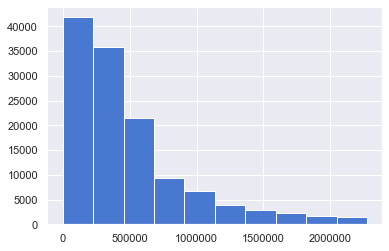

In [16]:
IQR = y.quantile(0.75) - y.quantile(0.25)
Upper_fence = y.quantile(0.75) + (IQR * 3)
#plt.xlim=
_ =plt.hist(y[y< Upper_fence])

### A FAZER COMEÇAREMOS AQUI O TRATAMENTO DE OUTLIERS


### Explorando e eliminando Missing Values
#### Mecanismo dos Missing values
Para entendermos completamente a importância da falta de dados, precisamos identificar de forma abrangente os motivos da ocorrência de dados ausentes. O primeiro passo é entender seus dados e, mais importante, o processo de coleta de dados. Isso pode levar à possibilidade de reduzir erros na coleta de dados. A natureza ou mecanismo de dados perdidos pode ser categorizado em três classes. Essas categorias são baseadas no grau de relação entre a natureza dos dados ausentes e os valores observados.

1) Missing Completely at Random (MCAR): 
- Significa que a natureza dos dados perdidos não está relacionada a nenhuma das variáveis, seja nos missings ou presentes. Nesse caso, o missingness na variável é completamente não sistemático. Por exemplo, vamos analisar um estudo que envolve determinar o motivo da obesidade entre crianças. O MCAR é quando os pais se esquecem de levar os filhos para a clínica.

2) Missing at Random (MAR):
- Significa que a natureza dos dados ausentes está relacionada aos dados observados, mas não aos dados ausentes. Usando o estudo acima, a falta de dados neste caso deve-se ao fato de os pais terem se mudado para uma cidade diferente e, portanto, as crianças tiveram que deixar o estudo - a falta de nada tem a ver com o estudo

3) Missing Not at Random (MNAR): 
- É conhecido como não-ignorável porque o mecanismo de missing não pode ser ignorado. Eles existem quando os valores ausentes não são nem MCAR nem MAR. Os valores em falta na variável estão relacionados com as variáveis observadas e não observadas. Um exemplo de MNAR é que os pais são ofendidos pela natureza do estudo e não querem que seus filhos sejam vítimas de bullying, então eles retiraram as crianças do estudo. A dificuldade com os dados do MNAR está intrinsecamente associada à questão da identificabilidade.

Perceba como o pacote missingno pode ajudar a detectar padrões nos dados

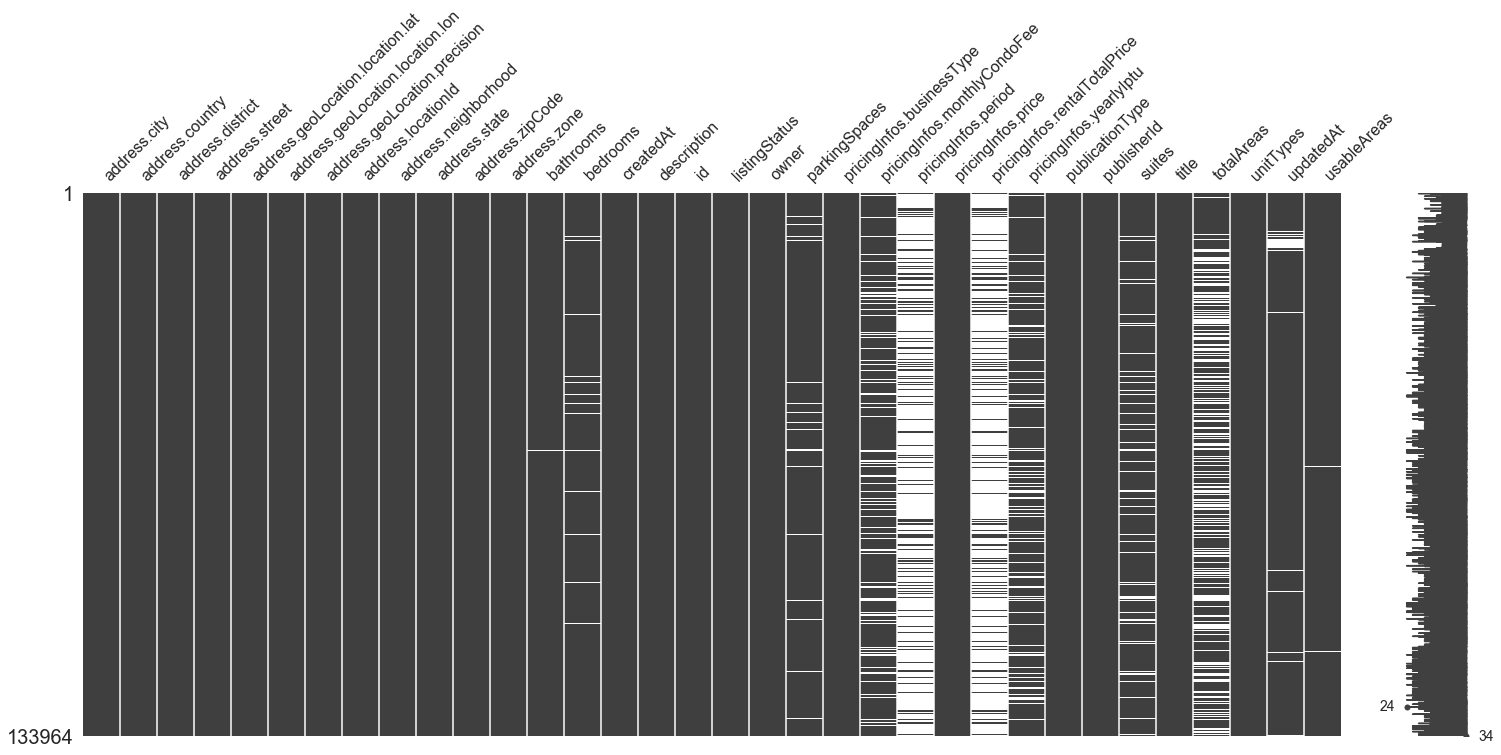

In [95]:
import missingno as msno
missingdata_df = list(train_eda.isnull().columns)
msno.matrix(train_eda[missingdata_df])

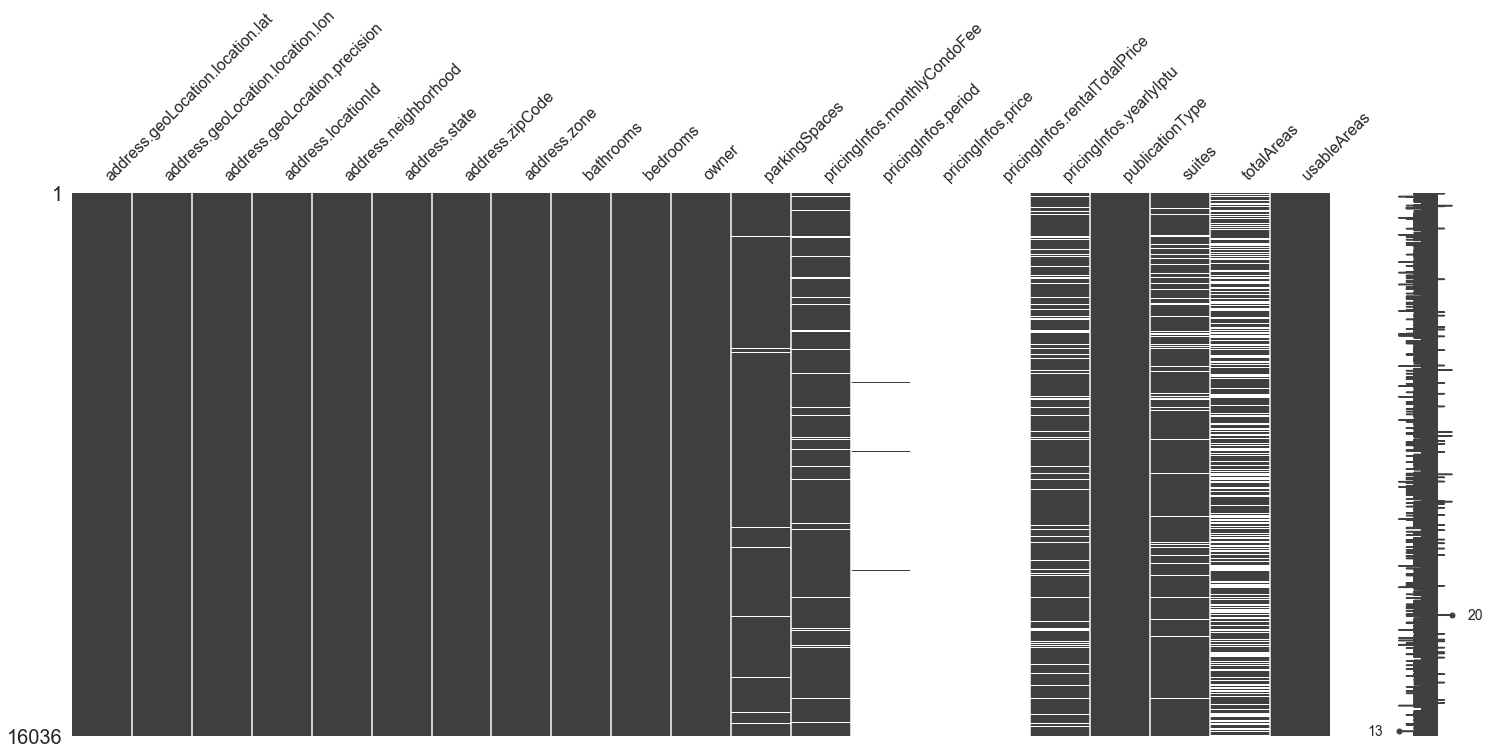

In [88]:
# Em Teste
test_missingdata_df = list(test.isnull().columns)
msno.matrix(test[test_missingdata_df])

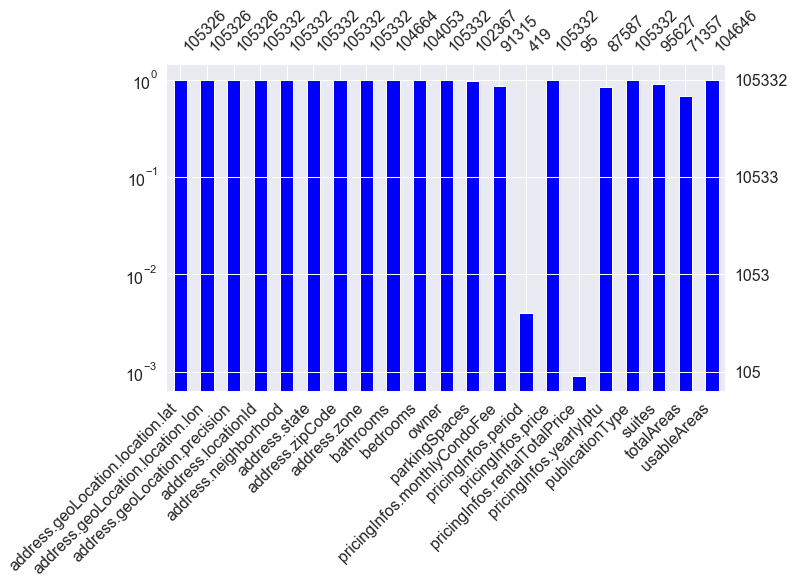

In [11]:
msno.bar(train_eda[missingdata_df], color="blue", log=True, figsize=(10,6))

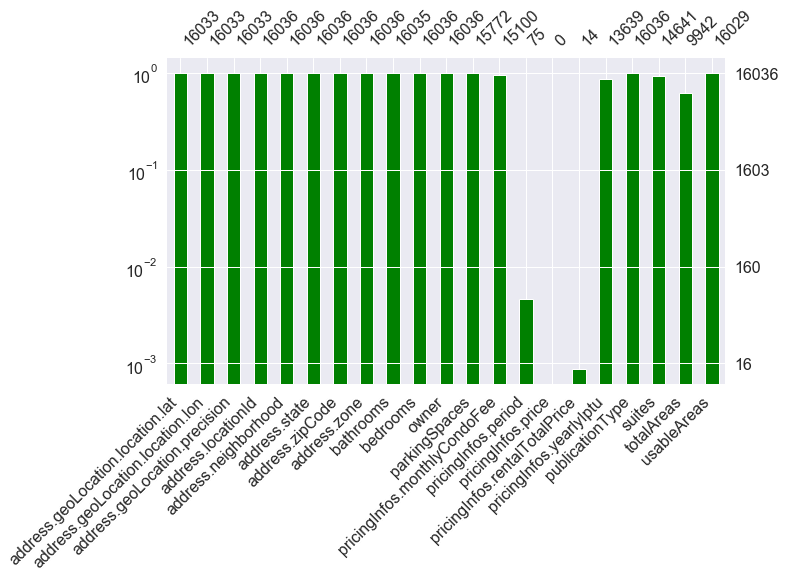

In [89]:
# teste
msno.bar(test[test_missingdata_df], color="green", log=True, figsize=(10,6))

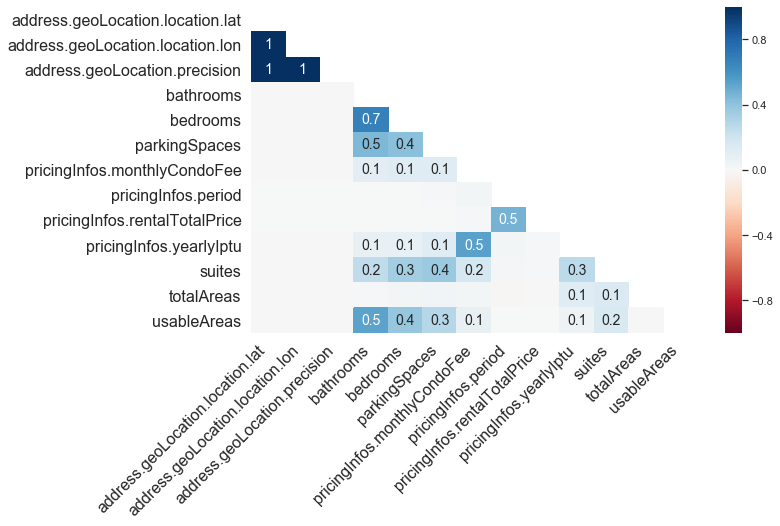

In [12]:
msno.heatmap(train_eda[missingdata_df], figsize=(10,6))

###### Acima  vemos uma grande correlação de missings de banheiros e quartos, garagens, suites e area usável, ou seja se exibissimos um grafico desses missings veriamos em um scatter uma relação bem positiva principalmente a 0.7
Tenho que decidir logo o que fazer com esses dados:

1) Poderia tentar usar mice:
- Preencher os dados de banheiros, quartos, garagem, iptu, condominio
- Ou ir para alternativa mais simples, criar colunas com a mediana pois os dados são assimétricos e preencher colunas com 0
- Preencher geolocation com a moda dos mesmos bairros e ruas

## Ponto Importante
A imputação de dados deve ser feita na fase de Treino e propagada de treino para Teste, dessa maneira evitamos overfiting

In [93]:
def fillGeolocationWithStreetMode(ds):
    ends = []
    for index, row in ds[ds['address.geoLocation.location.lat'].isnull()][['address.neighborhood',
                                                                       'address.street']].iterrows():
        ends.append([row.name, row[0], row[1]])
    for arr in ends:
        query = (ds['address.neighborhood'] == arr[1]) & \
        (ds['address.street'] == arr[2]) & (ds['address.geoLocation.location.lat'].notnull())
        ret = ds[query]
        if len(ret):
            ds['address.geoLocation.location.lat'].iloc[arr[0]] = ret['address.geoLocation.location.lat'].mode().values[0]
            ds['address.geoLocation.location.lon'].iloc[arr[0]] =ret['address.geoLocation.location.lon'].mode().values[0]
            ds['address.geoLocation.precision'].iloc[arr[0]] =ret['address.geoLocation.precision'].mode().values[0]
        else: #se não achou pela rua, vai pelo bairro
            query = (ds['address.neighborhood'] == arr[1]) & (ds['address.geoLocation.location.lat'].notnull())
            ret = ds[query]
            if len(ret):
                ds['address.geoLocation.location.lat'].iloc[arr[0]] = ret['address.geoLocation.location.lat'].mode().values[0]
                ds['address.geoLocation.location.lon'].iloc[arr[0]] =ret['address.geoLocation.location.lon'].mode().values[0]
                ds['address.geoLocation.precision'].iloc[arr[0]] =ret['address.geoLocation.precision'].mode().values[0]
            
    
fillGeolocationWithStreetMode(train_eda)        
fillGeolocationWithStreetMode(test)   

print(train_eda[['address.geoLocation.location.lat']].isnull().sum())
print(test[['address.geoLocation.location.lat']].isnull().sum())



address.geoLocation.location.lat    0
dtype: int64
address.geoLocation.location.lat    0
dtype: int64


In [110]:
def impute_na(ds, variable, median):
    ds[variable+'_median'] = ds[variable].fillna(median)
    ds[variable+'_zero'] = ds[variable].fillna(0) 
    
def fillNas(train,test):
    isNullNumericCols = train_eda.loc[:,train_eda.isna().any()].select_dtypes(include=np.number).columns
    for col in isNullNumericCols:
        median = train[col].median()
        impute_na(train,col,median)
        #a moda de teste deve ser passada para teste
        impute_na(test,col,median)
        
fillNas(train_eda,test) 

In [161]:
def applyGeoHash(ds):
    ds['geohash']=ds.apply(lambda x: gh.encode(x['address.geoLocation.location.lat'], 
                                               x['address.geoLocation.location.lon'], precision=5), axis=1)
    ds['geohash_high']=ds.apply(lambda x: gh.encode(x['address.geoLocation.location.lat'], 
                                               x['address.geoLocation.location.lon'], precision=10), axis=1)

In [162]:
applyGeoHash(train_eda)
applyGeoHash(test)

In [157]:
train_eda['address.street'].describe()

count     133964
unique     12933
top             
freq        7002
Name: address.street, dtype: object

In [164]:
train_eda['geohash_high'].describe()

count         133964
unique         50068
top       6gyf2mg8jp
freq             237
Name: geohash_high, dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002F9050E8208>,
      dtype=object)

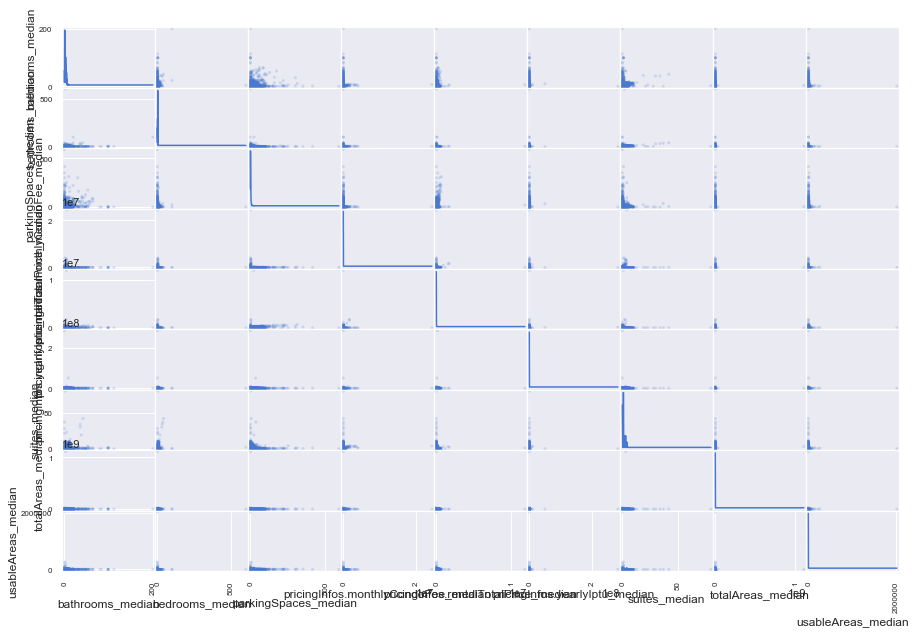

In [137]:
from pandas.plotting import scatter_matrix
median_cols = [x  for x in train_eda.loc[:,'bathrooms_median':].columns if '_media' in x]
#train_eda['parkingSpaces_median'].hist #(bins=15, figsize=(15, 6))#, layout=(2, 5))
#scatter_matrix(train_eda[median_cols], alpha=0.2, figsize=(15, 10), diagonal='kde')


### Primeira Limpeza UnitTypes somente apartamentos, então exclusão, BusinessTypes Somente Sales tambem excluir
- Somente por curiosidade vou dar uma olhada na unittypes 

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].set_title('Quantidade de Unittypes')
train_eda['unitTypes'].value_counts().plot.bar(ax=axes[0])
axes[1].set_title('Qual tipo retorna(ou promete) mais grana?')
train_eda.groupby('unitTypes')['pricingInfos.price'].sum().sort_values(ascending=False).plot.bar()

In [ ]:
test['unitTypes'].value_counts()

In [3]:
#dropando unitTypes
train_eda = train_eda.drop(labels='unitTypes', axis=1)
test = test.drop(labels='unitTypes', axis=1)

### pricingInfos.businessType

In [90]:
#agora dando uma olhada em business types em test e treino
print(test['pricingInfos.businessType'].value_counts())
print('-----------------------------')
print(train_eda['pricingInfos.businessType'].value_counts())

KeyError: 'pricingInfos.businessType'

In [5]:
# temos 28k a menos de dados nesse contexto seria desnecessário modelar com esses dados
train_eda = train_eda[train_eda['pricingInfos.businessType'] == 'SALE']
train_eda['pricingInfos.businessType'].value_counts()

SALE    105332
Name: pricingInfos.businessType, dtype: int64

In [6]:
#dropando nos dois datasets
train_eda = train_eda.drop(labels='pricingInfos.businessType', axis=1)
test = test.drop(labels='pricingInfos.businessType', axis=1)

In [7]:
arrToRemove = ['address.city', 'address.country', 'address.district',
        'createdAt', 'description','id', 'listingStatus',
        'publisherId','title', 'updatedAt']
train_eda = train_eda.drop(labels=arrToRemove, axis=1)
test = test.drop(labels=arrToRemove, axis=1)

### Algumas limpezas e remoções vamos ver se está tudo certo

In [ ]:
zap.getSomeStats(train_eda, 'pricingInfos.price')

In [ ]:
test.info()

In [ ]:
zap.showCatsNotInTest(train_eda,)

### Vamos analizar geralmente todas as colunas
- Como vimos nos números da assimetria a presença é grande de outliers nesses dados
- vou usar log10(x+1) para podermos visualizar melhor

In [ ]:
a =train_eda[['bathrooms', 'bedrooms',  'parkingSpaces',
        'pricingInfos.price',
       'pricingInfos.rentalTotalPrice', 
       'suites', 'totalAreas',
       'usableAreas']].hist(bins=15, figsize=(15, 6), layout=(2, 4))

In [ ]:
for var in ['bathrooms', 'bedrooms',  'parkingSpaces',
        'pricingInfos.price',
       'suites',
       'usableAreas']:
    zap.plotDistAndLog(train_eda[var].fillna(0))

In [ ]:
zap.plotDsNullPercent(train_eda)

In [ ]:
x = train_eda[['bathrooms', 'bedrooms',  'parkingSpaces',
       'suites']]
#xscaled['pricingInfos.rentalTotalPrice'] = xscaled['pricingInfos.rentalTotalPrice'].fillna(0.01)
x.plot.box()
#xscaled.isnull().sum()
#x,lambdafit = stats.boxcox(xscaled)
#xscaled = transformer.transform(xscaled)
#pd.DataFrame(x).hist(bins=15, figsize=(15, 6), layout=(2, 4))

In [ ]:
xscaled.head()

In [ ]:
train_eda['owner_bin'] = train_eda['owner'].map({True:1,False:0})
test['owner_bin'] = test['owner'].map({True:1,False:0})
train_eda = train_eda.drop(labels='owner',axis=1)
test = test.drop(labels='owner',axis=1)

In [ ]:
train_eda.groupby('owner')['pricingInfos.price'].describe().T

In [ ]:
g = sns.pairplot(train_eda.loc[:,['bathrooms', 'bedrooms',  'parkingSpaces',
        'pricingInfos.price',
       'pricingInfos.rentalTotalPrice', 
       'suites', 'totalAreas',
       'usableAreas']])

### address.neighborhood

In [ ]:
train_eda['address.neighborhood'].value_counts().head(10)

In [ ]:
test['address.neighborhood'].value_counts().head(10)

O preço tinha vendas de 70 reais, vamos verificar agora depois da remoção de rents

In [ ]:
train_eda[train_eda['pricingInfos.price']< 1000]

In [ ]:
def plotPivotTableTop10(ds,category, target):
    pivot = ds.pivot_table(index=category, values=target, aggfunc=np.median)
    plt.xlabel(category)
    plt.ylabel('Media de ' + target)
    plt.xticks(rotation=0)
    plt.show()


In [ ]:
train = zap.readAndFlatDataSet('source-4-ds-train.json')

In [ ]:
arrtrain =  train['address.neighborhood'].value_counts().index
arrtest = test['address.neighborhood'].value_counts().index
len(set(arrtest).difference(arrtrain))

In [ ]:
multi_cat_cols = []
for col in train_eda.columns:
    if train_eda[col].dtypes =='O': # if variable  is categorical
        if len(train_eda[col].unique())>10: # and has more than 10 categories
            multi_cat_cols.append(col)  # add to the list
            #print(train_eda.groupby(col)[col].count()/np.float(len(train_eda))) # and print the percentage of observations within each category
            #print()

In [ ]:
train.groupby('address.neighborhood')['pricingInfos.price'].median().sort_values(ascending=False)

In [ ]:
for idx in ['address.locationId',
       'address.neighborhood', 'address.zipCode',
       'address.zone','publicationType']:
    
    pivot = train.pivot_table(index=idx, values='pricingInfos.price', 
                          aggfunc=np.mean).sort_values(by='pricingInfos.price',ascending=False).iloc[0:10]
    pivot.plot(kind='bar', color='blue')
    plt.xlabel(idx)
    plt.ylabel('Media do Preço')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
pivot

In [ ]:
# let's go ahead and have a look at how many observations we would drop
print('total sem NA(s)', train_eda.dropna().shape[0])
print('total de linhas no dataset: ',  train_eda.shape[0])
print('percentagem sem missings: ',  train_eda.dropna().shape[0]/ np.float( train_eda.shape[0]))

In [ ]:
zap.plotScatters(train_eda)

In [ ]:
cat_cols = train_eda[train_eda.select_dtypes(include=['object']).columns]
num_cols = train_eda[train_eda.select_dtypes(exclude=['object']).columns]

In [ ]:
fig = plt.figure(figsize=(15, 10))
#num_cols.mean().sort_values().plot(style='.')
#gt_matrix(train_eda, num_cols,16)
train_eda['address.neighborhood'].count_values()


In [ ]:
train_eda['address.neighborhood'].nunique()

In [ ]:
train_eda[['pricingInfos.price']].hist(by=train_eda['publicationType'])

In [ ]:
sns.set(font_scale=1.5)


In [ ]:
plt.plot(train_eda['pricingInfos.price'],'.')

In [ ]:
x = train_eda['usableAreas']
y = train_eda['pricingInfos.price']
plt.scatter(range(len(x)),x, c=y)

In [ ]:
fig = plt.figure(figsize=(20, 15))
fig4 = fig.add_subplot(224); 
sns.scatterplot(x = train_eda.usableAreas, y = train_eda['pricingInfos.price'], hue=train.publicationType, palette= 'Spectral')


In [ ]:
#type(train_eda['pricingInfos.price'])
QQ_plot(train_eda['pricingInfos.price'], 'Sales Price')

In [ ]:
#sns.set(palette='dark')
plt.figure(figsize=(15, 10))
sns.heatmap(train_eda.corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis dos dados')
plt.show()

In [ ]:
train_eda[['pricingInfos.price']].hist(bins=10)

In [ ]:
sns.scatterplot(x = 'usableAreas', y = 'pricingInfos.price', data=train_eda, palette= 'Spectral')

#sns.boxplot(x='totalAreas', y='pricingInfos.price', data=train_final[['totalAreas', 'pricingInfos.price']])

In [ ]:
train_eda['suites'].describe()

In [ ]:
train_final.describe().transpose()

In [ ]:
train_final.dropna().info()

### Vamos analizar as correlações mais visualmente...

In [ ]:
#sns.set(palette='dark')
plt.figure(figsize=(15, 10))
sns.heatmap(train_final.dropna().corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis dos dados')
plt.show()

In [ ]:
train_final.describe().transpose()

In [ ]:
train_final.groupby(['address.state', 'address.locationId']).count()

In [ ]:
#train_final['address.state'].count()
train_final.groupby('address.state').mean()

In [ ]:
train_final.groupby('address.neighborhood').sum().sort_values('pricingInfos.price', ascending=False).head(5)

In [ ]:
train_final.describe(include=['category'])

In [ ]:
train_final = train_eda.drop(labels=['address.city', 'address.country', 'address.district',
       'address.geoLocation.precision', 'address.locationId',
       'address.neighborhood', 'address.state', 'address.zipCode',
       'address.zone',  'listingStatus',
       'pricingInfos.businessType', 'pricingInfos.period', 'publicationType',
        'unitTypes'], axis=1)

In [ ]:
train_eda

In [ ]:
from fancyimpute import KNN

In [ ]:
train_eda[(train_eda['usableAreas'].isnull() & train_eda['totalAreas'].notnull())].head(1)

In [ ]:
train_eda[['usableAreas', 'totalAreas', 'bedrooms', 'bathrooms', 'parkingSpaces','pricingInfos.price',
          'suites']].tail(10)

In [ ]:

print(train_final.isnull().sum())
#train_final.select_dtypes(include=np.number).columns
#train_final.drop(labels=['publisherId'], axis=1, inplace=True)
['address.geoLocation.location.lat', 'address.geoLocation.location.lon',
       'bathrooms', 'bedrooms', 'parkingSpaces',
       'pricingInfos.monthlyCondoFee', 'pricingInfos.price',
       'pricingInfos.rentalTotalPrice', 'pricingInfos.yearlyIptu', 'suites',
       'totalAreas', 'usableAreas']

In [ ]:
from statsmodels.imputation import mice
imp = mice.MICEData(train_final)

In [ ]:
#imp.plot_bivariate('totalAreas','usableAreas')
#imp.plot_missing_pattern()
#imp.plot_imputed_hist('totalAreas')
imp. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_final.drop(labels=['pricingInfos.price'], axis=1),
    train_final['pricingInfos.price'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

In [ ]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

In [ ]:
efs1 = EFS(RandomForestRegressor(n_jobs=4), 
           min_features=1,
           max_features=6, 
           scoring='r2',
           print_progress=True,
           cv=2)

efs1 = efs1.fit(np.array(X_train), y_train)